# Tarea 3: Los K-vecinos 

## Introducción

<img src="images/vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="images/algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

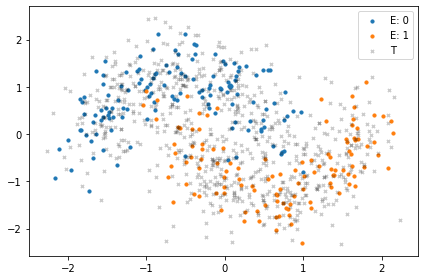

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();


## 1. Mediciones de KNN

### 1.1 Utilizando la magia %timeit

Podemos medir el tiempo promedio de un script, función o expresión de Python de forma conveniente usando la magia timeit. Esta magia se basa en el módulo estándar de Python timeit.
En este caso, se ejecuta 4 veces la función, realizando 2 loops en cada iteración y especificamos que el resultado tenga una precisión de 8 dígitos. 

In [3]:
timeitResult = %timeit -r4 -n2 -p8 -o Z_Y_1 = KNN(x,y,z)

2.0302973 s ± 37.192291 ms per loop (mean ± std. dev. of 4 runs, 2 loops each)


In [29]:
sum(timeitResult.all_runs)/float(len(timeitResult.all_runs))

4.179279974250221

In [30]:
timeitResult.compile_time

7.000000000090267e-05

Notamos que la función no parece ser muy eficiente ya que tarda aproximadamente 2 segundos en finalizar.

### 1.2 Utilizando la magia %prun 

Con **%prun** podemos visualizar el número de veces que son llamados los sub-métodos de una función, y el tiempo que consume cada uno.

In [10]:
%prun -s cumtime KNN(x,y,z)

# Para facilitar la visualización también podemos usar SnakeViz.
#%load_ext snakeviz
#%snakeviz KNN(x,y,z) #-t

Podemos ver que el tiempo total es mayor que el que medimos con timeit ( tarda aproximadamente 500 ms más ). Esto se debe al overhead introducido por prun.
También pudimos evidenciar que gran parte del tiempo de ejecución se invierte en los método **reduce** y **sum**, los cuales no consumen mucho tiempo por llamado, pero si al invocarse 189000 veces. La operación más costosa es **argsort** pero por suerte solo se llama 1 vez. Si analizamos los tiempos acumulados, vemos que el cuello de botella se encuentra en los lugares donde se utiliza **sum**, por ejemplo en el cálculo de distancia.


### 1.3 Utilizando la magia %lprun

Esta magia nos permite estudiar el tiempo de ejecución y número de llamados de cada linea de nuestro código por separado.

In [2]:
%load_ext line_profiler
%lprun -f KNN KNN(x,y,z)

Vemos que un 94.6% del tiempo de cómputo se efectúa al ejecutar la línea 21 de la función KNN. La operación de esa linea consiste en el cálculo de distancia entre vecinos. También podemos notar que los ciclos **for** ocupan un 4.1 % y que el método **argsort** aún siendo llamado 1 vez, consume el 0.3% del tiempo.

### 2. KNN en Cython

Implementamos 3 funciones de KNN con Cython **CKNN1**, **CKNN2** y **CKNN3**. En cada una vamos realizando mejoras respecto a la anterior. También incluimos la implementación KNN de sklearn para comparar.

In [2]:
# Requerido para OpenMP en Mac OS X
#import os
#os.environ["CC"] = "/usr/local/opt/llvm/bin/clang"

%load_ext cython

### CKNN1
En la primera mejora definimos los tipos de cada variable ( donde sea posible ) y reemplazamos las funciones de numpy para calcular la distancia por un for y funciones de C.

In [6]:
%%cython -l m

import numpy as np
cimport numpy as npc
import cython

cdef extern from "math.h":
    double fabs(double)
    double pow(double,double)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef npc.ndarray CKNN1(X, Y, Z, unsigned char k=5, double p = 2.0):

    cdef long [:] C = np.unique(Y) 
    cdef unsigned short N = X.shape[0] # Número de muestras conocidas
    cdef unsigned short D = X.shape[1] # Número de dimensiones
    cdef unsigned short M = Z.shape[0] # Número de muestras a entrenar
    
    # Exponente inv
    cdef double expo = 1.0/p;
    
    dist = np.zeros(shape=(M, N))
    
    for i in range(M):
        for j in range(N):
            for d in range(D):
                dist[i, j] += pow(fabs(Z[i,d] - X[j,d]),p)
            dist[i, j] = pow(dist[i, j],expo)
            
    neighbours = np.argsort(dist, axis=1)[:, :k]
    Z_Y = np.zeros(shape=(M, ))
    for i in range(M):
        criterion = np.zeros(shape=(len(C),))
        for c in C:
            criterion[c] = np.sum(1./dist[i, neighbours[i]][Y[neighbours[i]] == c])
        Z_Y[i] = np.argmax(criterion)
    return Z_Y

Con esto logramos reducir el tiempo de 2000 ms a 470 ms (4 veces más rapido).

### CKNN2
En la segunda mejora, reemplazamos las funciones de numpy para ordenar y calcular las clases. En vez de almacenar todas las distancias en un "gran" arreglo, utilizamos arreglos de largo K para ir almacenando las distancias más pequeñas de cada iteración junto los indices.
De esas K distancias más pequeñas almacenamos la mayor para reemplazarla únicamente si la nueva distancia calculada es menor. De esta forma realizamos menos iteraciones para encontrar los K elementos que si ordenaramos los arreglos al final. Además al no utilizar numpy, no obtenemos errores al definir los tipos de datos del argumento.

In [7]:
%%cython -l m

import cython
import numpy as np
cimport numpy as npc

cdef extern from "math.h":
    double fabs(double)
    double pow(double,double)

@cython.boundscheck(False)
@cython.initializedcheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef npc.ndarray CKNN2(double [:,::1] X, long [:] Y, double [:,::1] Z, unsigned char k=5, double p = 2.0):
    
    # Clases
    cdef long [:] c = np.unique(Y) 
    
    cdef unsigned short C = c.shape[0] # Número de clases
    cdef unsigned short N = X.shape[0] # Número de muestras conocidas
    cdef unsigned short D = X.shape[1] # Número de dimensiones
    cdef unsigned short M = Z.shape[0] # Número de muestras a entrenar
        
    # Exponente inv
    cdef double expo = 1.0/p;
    
    # Indices de los k mas cercanos
    cdef unsigned short [:] kInds = np.zeros(k,dtype='uint16')
    
    # Distancias de los k mas cercanos
    cdef double [:] kDists = np.zeros(k,dtype='float64')
    
    # Indice de la distancia más grande ( dentro de las k más pequeñas )
    cdef unsigned short maxDistIndex = 0
    
    # Indice de la clase ganadora
    cdef unsigned short winnerClassIndex = 0
    cdef double winnerClassDist = 0.0
    
    # Variable para almacenar suma de distancias inversas por clase ( para decidir clase )
    cdef double [:] cRes = np.zeros(C,dtype='float64')
    
    # Variable temporal para calcular distancia
    cdef double dist = 0.0
    
    # Resultados
    cdef unsigned char [:] YZ = np.zeros(M,dtype='uint8')
    
    # Loop cada elemento de Z
    for i in range(M):
        
        # Reinicia el índice de la clase ganadora
        winnerClassIndex = 0
        winnerClassDist = 0.0
        
        # Reinicia la suma de distancias inversas por clase
        for d in range(C):
            cRes[d] = 0.0
            
        # Asigna un valor inicial grande a las distancias
        for d in range(k):
            kDists[d] = 1.7976931348623157e+308 # Máximo valor de un double
        
        # Asigna la primera distancia como la mayor ( inicialmente son todas iguales)
        maxDistIndex = 0
        
        # Loop cada elemento de X
        for j in range(N):
            
            # Calcula distancia
            dist = 0.0
            for d in range(D):
                dist += pow(fabs(Z[i,d] - X[j,d]),p)
            dist = pow(dist,expo)
            
            # Si la distancia es menor que la mayor en kDists
            if dist < kDists[maxDistIndex]:
                
                # Reemplaza el valor
                kDists[maxDistIndex] = dist
                
                # Guarda el índice del elemento X actual
                kInds[maxDistIndex] = j
                
                # Vuelve a buscar el mayor actual en kDists
                dist = 0
                for l in range(k):
                    if kDists[l] > dist:
                        dist = kDists[l]
                        maxDistIndex = l
        
        # Calcula la cercanía ponderada por distancia de cada clase
        for d in range(k):
            
            # Suponiendo que los nombres de las clases siempre son 0,1,...,C-1
            cRes[Y[kInds[d]]] += 1.0/kDists[d]
            
        # Busca la clase ganadora
        for d in range(C):
            if cRes[d] > winnerClassDist:
                winnerClassDist = cRes[d]
                winnerClassIndex = d
        
        # Guarda la clase ganadora en el arreglo
        YZ[i] = c[winnerClassIndex]
                        
            
    return YZ.base

Con esto logramos reducir el tiempo de 470 ms a 19 ms, 100 veces más rápida que la inicial.

### CKNN3
Por último, utilizamos multithreading con OpenMP, por lo que simplemente portamos el código anterior para poder paralelizar el **for** que calcula los K vecinos de cada elemento de Z. 
En nuestra máquina obtuvimos mejores resutlados con 12 hilos.

In [3]:
%%cython -l m --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
import numpy as np
cimport numpy as npc
from cython.parallel import prange

cdef extern from "math.h" nogil:
    double fabs(double)
    double pow(double,double)

@cython.boundscheck(False)
@cython.initializedcheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef npc.ndarray CKNN3(double [:,::1] X, long [:] Y, double [:,::1] Z, unsigned char k=5, double p = 2.0):
    
    # Clases
    cdef long [:] c = np.unique(Y) 
    
    cdef unsigned short C = c.shape[0] # Número de clases
    cdef unsigned short N = X.shape[0] # Número de muestras conocidas
    cdef unsigned short D = X.shape[1] # Número de dimensiones
    cdef unsigned short M = Z.shape[0] # Número de muestras a entrenar
        
    # Exponente inv
    cdef double expo = 1.0/p;
    
    # Indices de los k mas cercanos
    cdef unsigned short [:,::1] kInds = np.zeros((M,k),dtype='uint16')
    
    # Distancias de los k mas cercanos
    cdef double [:,::1] kDists = np.full((M,k),1.7976931348623157e+308,dtype='float64')
    
    # Indice de la distancia más grande ( dentro de las k más pequeñas )
    cdef unsigned short [:] maxDistIndex = np.zeros(M,dtype='uint16')
    
    # Indice de la clase ganadora
    cdef unsigned short [:] winnerClassIndex = np.zeros(M,dtype='uint16')
    cdef double [:] winnerClassDist = np.zeros(M,dtype='float64')
    
    # Variable para almacenar suma de distancias inversas por clase ( para decidir clase )
    cdef double [:,::1] cRes = np.zeros((M,C),dtype='float64')
    
    # Variable temporal para calcular distancia
    cdef double [:] dist = np.zeros(M,dtype='float64')
    
    # Resultados
    cdef unsigned char [:] YZ = np.zeros(M,dtype='uint8')
    
    # Indices
    cdef short i,j,d,l = 0
    
    # Loop cada elemento de Z
    with nogil:
        for i in prange(M,num_threads=12):

            # Loop cada elemento de X
            for j in range(N):

                # Calcula distancia
                dist[i] = 0.0
                for d in range(D):
                    dist[i] += pow(fabs(Z[i,d] - X[j,d]),p)
                dist[i] = pow(dist[i],expo)

                # Si la distancia es menor que la mayor en kDists
                if dist[i] < kDists[i,maxDistIndex[i]]:

                    # Reemplaza el valor
                    kDists[i,maxDistIndex[i]] = dist[i]

                    # Guarda el índice del elemento X actual
                    kInds[i,maxDistIndex[i]] = j

                    # Vuelve a buscar el mayor actual en kDists
                    dist[i] = 0
                    for l in range(k):
                        if kDists[i,l] > dist[i]:
                            dist[i] = kDists[i,l]
                            maxDistIndex[i] = l

            # Calcula la cercanía ponderada por distancia de cada clase
            for d in range(k):

                # Suponiendo que los nombres de las clases siempre son 0,1,...,C-1
                cRes[i,Y[kInds[i,d]]] += 1.0/kDists[i,d]

            # Busca la clase ganadora
            for d in range(C):
                if cRes[i,d] > winnerClassDist[i]:
                    winnerClassDist[i] = cRes[i,d]
                    winnerClassIndex[i] = d

            # Guarda la clase ganadora en el arreglo
            YZ[i] = c[winnerClassIndex[i]]
                        
            
    return YZ.base
            

Con esta última mejora, logramos reduir el tiempo de 19 ms a 4.8 ms, 400 veces más rápida que la inicial.

### KNN de Sklearn

También implementamos la versión de KNN para comparar.

In [9]:
def sklearnKNN(x,y,z):
    knn = KNeighborsClassifier(n_neighbors = 5,weights='distance',p=2)
    knn.fit(x,y)
    return knn.predict(z)

## Resultados

### KKN original con Python

In [7]:
%timeit -r4 -n4 KNN(x,y,z)

1.97 s ± 20.9 ms per loop (mean ± std. dev. of 4 runs, 4 loops each)


### Mejora 1 KKN con Cython ( distancia )

In [8]:
%timeit -r4 -n4 CKNN1(x,y,z)

436 ms ± 8.28 ms per loop (mean ± std. dev. of 4 runs, 4 loops each)


### Mejora 2 KKN con Cython ( sorting )

In [11]:
%timeit -r4 -n4 CKNN2(x,y,z)

18.2 ms ± 728 µs per loop (mean ± std. dev. of 4 runs, 4 loops each)


### Mejora 3 KKN con Cython ( multithreading )

In [15]:
%timeit -r4 -n4 CKNN3(x,y,z)

4.81 ms ± 585 µs per loop (mean ± std. dev. of 4 runs, 4 loops each)


### Implementación de KKN de sklearn

In [53]:
%timeit -r4 -n4 sklearnKNN(x,y,z)

2.56 ms ± 304 µs per loop (mean ± std. dev. of 4 runs, 4 loops each)


Como podemos ver nuestra mejor versión tarda aproximadamente 4.8 ms, lo cual es una gran mejora respecto a la función inicial, pero la versión de sklearn sigue siendo el doble de rápida, aún no utilizando multithreading.

### Verificamos si se obtienen los mismos resultados

In [54]:
# Resultado con KNN Python
ZY = KNN(x,y,z)

In [55]:
print("KNN == CKNN1:\t\t",(ZY == CKNN1(x,y,z)).all())
print("KNN == CKNN2:\t\t",(ZY == CKNN2(x,y,z)).all())
print("KNN == CKNN3:\t\t",(ZY == CKNN3(x,y,z)).all())
print("KNN == sklearnKNN:\t",(ZY == sklearnKNN(x,y,z)).all())

KNN == CKNN1:		 True
KNN == CKNN2:		 True
KNN == CKNN3:		 True
KNN == sklearnKNN:	 True


Todas las funciones entregan numéricamente el mismo resultado. Sin embargo el tipo de dato de los arreglos numpy que retorna nuestro KNN es **uint8**, a diferencia de la función original que es **float64**.

#### 2.3 Gráfica del Speed-up

Calculamos el speed-up dividiendo los tiempos del KNN original por los de nuestro mejor KNN .

In [10]:
# Tamaños de muestras
N = np.array([10,50,100,500,1000,5000,10000])

def calcula_tiempos():
    # Almacena tiempos
    times = np.zeros((len(N),2),dtype='float64')

    # Calculamos valores
    for i in range(len(N)):
        e, t = create_data(N=N[i])
        xx, yy = e
        zz, _ = t
        timeit1 = %timeit -r1 -n1 -o CKNN3(xx,yy,zz)
        timeit2 = %timeit -r1 -n1 -o KNN(xx,yy,zz)
        times[i,0] = timeit1.best
        times[i,1] = timeit2.best
        
    # Almacenamos resultados
    np.save("Tiempos.npy",times)

# Desactivamos ya que requiere mucho tiempo
#calcula_tiempos()

# Cargamos resultados calculados previamente
times = np.load("Tiempos.npy")

# Calculamos speedups
speedups = times[:,1]/times[:,0]

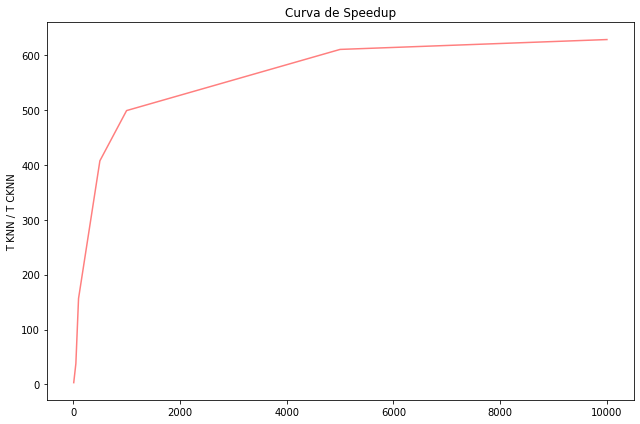

In [11]:
fig, ax = plt.subplots(figsize=(9,6),tight_layout=True)
ax.set_title('Curva de Speedup')
ax.set_ylabel('T KNN / T CKNN')
plt.plot(N, speedups, c='red',alpha=0.5)
plt.show()

De la curva se observa que a partir de las 5000 muestras, donde nuestro KNN resulta ser aproximadamente 600 veces más rápido que el KNN original, el aumento de speedup se estabiliza.

### 3. Validación cruzada

Antes de comenzar a entrenar nuestro modelo, verificamos el balance de los datos.

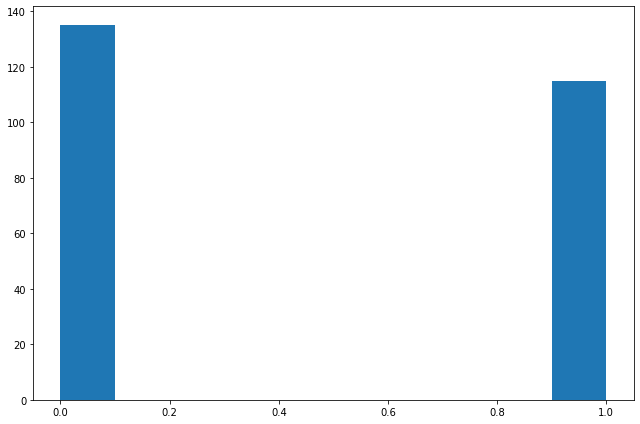

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6),tight_layout=True)
_ = plt.hist(y)

In [31]:
k_values = np.arange(1,31,dtype='float64')
p_values = np.arange(1,11,dtype='float64')

# Almacena todos los resultados (Acurracy_avg,k,p)
all_params = np.zeros((len(k_values)*len(p_values),3))

# Mejor resultado (Acurracy_avg,k,p)
best_params = np.zeros(3,dtype='float64')

# kFold de 7 divisiones
kf = KFold(n_splits=7,shuffle=True,random_state=0)

# Validación cruzada para encontrar mejor k y p
index = 0
for k in k_values:
    for p in p_values:
        avg_acurracy = 0.0
        for train_index, val_index in kf.split(x):

            # Realiza predicción
            zy = CKNN3(x[train_index],y[train_index],x[val_index],k,p)

            # Valores correctos / total
            avg_acurracy += float(np.count_nonzero((zy == y[val_index])))/float(len(zy))

        # Almacena Acurracy, k y p
        all_params[index,0] = avg_acurracy/float(kf.n_splits)
        all_params[index,1] = k
        all_params[index,2] = p

        # Guarda mejor Acurracy y parámetros
        if all_params[index,0] > best_params[0]:
            best_params = all_params[index,:]
        index+=1
print(best_params)

[ 0.9515873 17.         2.       ]


In [148]:
print(best_params)

[ 0.952 15.     2.   ]


In [67]:
print(best_params)

[ 0.952 17.     2.   ]


### 4. Métricas que evalúan el clasificador
Se implementaron distintas métricas que permiten evaluar la exactitud y desempeño de los algoritmos KNN al momento de identificar las dos mitades de círculos entrelazados.


#### 4.1 Matriz de Confusión
La matriz de confusión es una herramienta muy útil para valorar cómo de bueno es un modelo clasificación basado en aprendizaje automático. En particular, sirve para mostrar de forma explícita cuándo una clase es confundida con otra, lo cual nos, permite trabajar de forma separada con distintos tipos de error. 

En una matriz de confusión, por lo general:

- los elementos de la diagonal representan las clasificaciones correctas

- los elementos fuera de la diagonal representan las clasificaciones erroneas

- las filas corresponden a las clases reales

- las columnas corresponden a las clases predichas por el clasificador

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(5, 4), tight_layout=True)

plot_confusion_matrix(knn, # Clasificador
                      x, # Datos
                      y, # Etiquetas
                      ax=ax, # subeje para gráficar
                      display_labels=np.array(['Naranjo', 'Azul']), #Nombres de las clases
                      cmap=plt.cm.plasma, # Escala de colores
                      normalize=None #Permite escoger entre cantidades y porcentajes
                     );

#### 4.2 Exactitud
El accuracy se calcula como la cantidad de ejemplos predichos correctamente dividido por la cantidad total de ejemplos y es un valor en el rango [0,1]. Por definición corresponde a la suma de la diagonal de la matriz de confusión dividido por el total de ejemplos

In [ ]:
from sklearn.metrics import accuracy_score

yhat = knn.predict(x)

print(accuracy_score(y, yhat))

print(knn.score(x[:, :2], y))

#### 4.3 Curva de desempeño

En problemas de clasificación binaria es mucho más informativo medir el desempeño utilizando curvas Receiver operating characteristic (ROC), que son curvas en las que se presenta la sensibilidad (o verdaderos positivos) en función de los falsos positivos (complementario de la especificidad) para distintos puntos de corte.

A modo de resumen, una interpretación superficial de las curvas sigue la siguiente figura.

<img src="images/roc.png" width="400">

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, knn.predict_proba(x)[:, 1])
idx = np.where(tpr > 0.9)[0][0]
print(f"{fpr[idx]:0.4f}, {tpr[idx]:0.4f}, {thresholds[idx]:0.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr)
ax.scatter(fpr[idx], tpr[idx], s=50, c='k')
ax.set_xlabel('Tasa de falsos positivos')
ax.set_ylabel('Tasa de verdaderos positivos');